# Numerical Integration

## Objectives
* Learn to implement a few simple integration routines
* Use built-in tools (Numpy and Scipy) to integrate
* Study best practices

Let us define the problem, we want to integrate the function $f(x)$ as
$$
\int_a^b f(x)
$$
how do we do this numerically?.

Let us consider a very simple method and we go from there

<img src="fig/Integral.approxi.jpg" alt="Scientific Computing with Python" style="width:60%" align="left">

<img src="fig/Integral.trapez.jpg" alt="Scientific Computing with Python" style="width:60%" align="left">

Standard imports

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Aside: I wanted to setup a fun function to integrate. Here's how I played with a polynomial till I got one I liked. First, make a (mostly empty) plot to put our interactive output:

In [10]:
from ipywidgets import interact

In [11]:
x = np.linspace(0, 10)

<IPython.core.display.Javascript object>


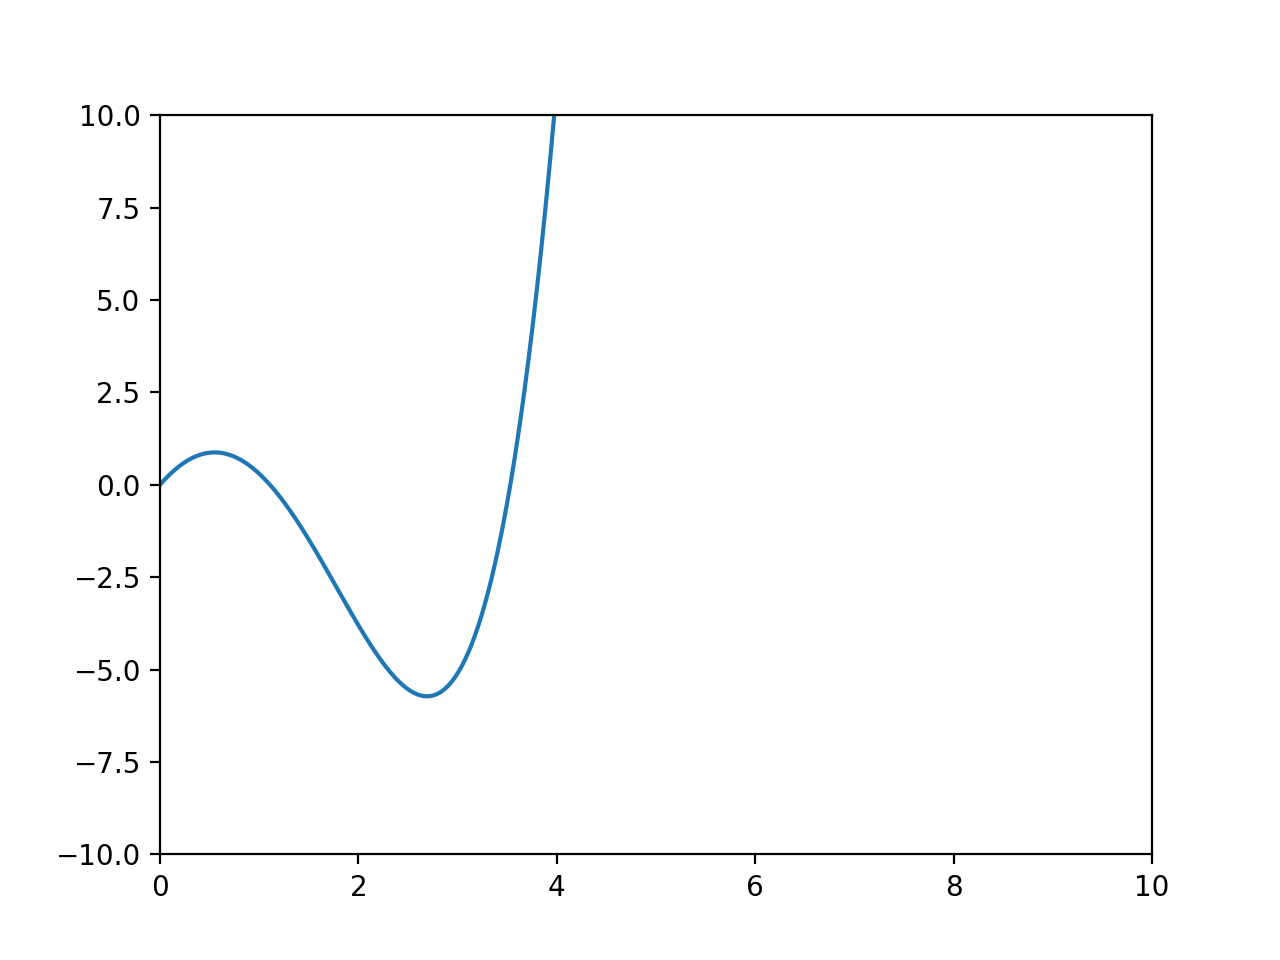

In [6]:
fig, ax = plt.subplots()
(lines,) = plt.plot([], [])
ax.set_xlim(0, 10)
ax.set_ylim(-10, 10)
plt.show()

In [7]:
def f(a=(-1.0, 1.0), b=(-1.0, 1.0), c=(-10.0, 10.0), d=(-10.0, 10.0)):
    lines.set_data(x, np.poly1d([a, b, c, d, 0])(x))


interact(f)

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

<function __main__.f(a=(-1.0, 1.0), b=(-1.0, 1.0), c=(-10.0, 10.0), d=(-10.0, 10.0))>

## Trapezoid

Okay, I have something I like. Let's compute:

$$
Ax^4 + Bx^3 + Cx^2 + Dx + E
$$

Where $A=-0.1, B=1.0, C=-3.1, D=3.6, E=0.5$. I've just picked nice numbers to give an interesting plot and integral.

<IPython.core.display.Javascript object>


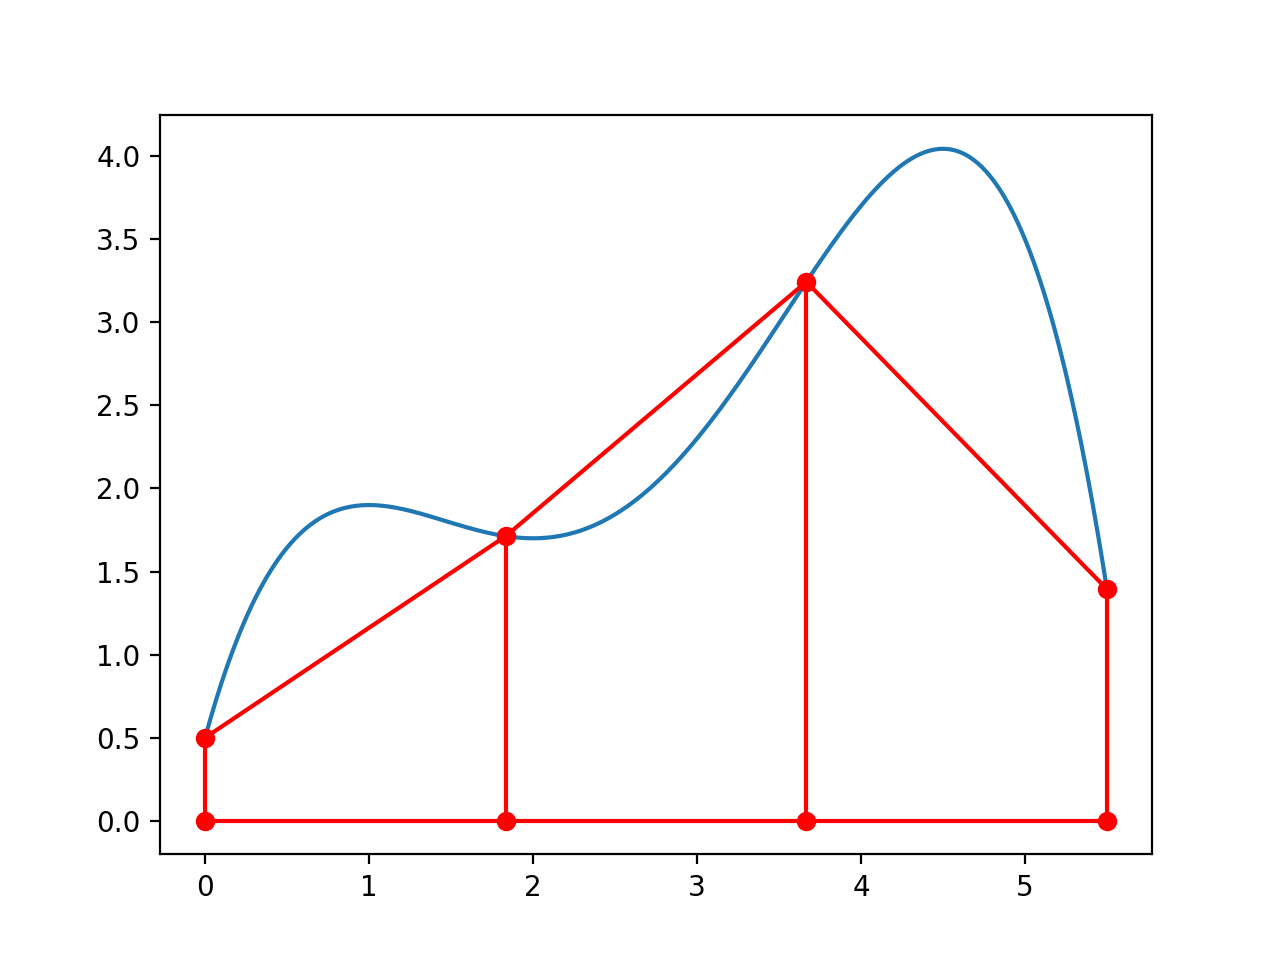

In [12]:
x = np.linspace(0, 5.5, 500)
f = np.poly1d([-0.1, 1.0, -3.1, 3.6, 0.5])
y = f(x)
x_i = np.linspace(0, 5.5, 4)
y_i = f(x_i)

fig, ax = plt.subplots()
plt.plot(x, y)
plt.plot(x_i, y_i, "o-r")
plt.plot(x_i, y_i * 0, "o-r")
plt.vlines(x_i, y_i * 0, y_i, "r")
plt.show()

Let's try integrating with several different values of N (picking odd values for later use - we could have even numbers if we wanted). Let's also compare with `np.trapz`.

In [13]:
for i in 3, 5, 7, 11, 21, 101, 1001:
    x_i = np.linspace(0, 5.5, i)
    y_i = f(x_i)
    h = np.diff(x_i)[0]
    my_intg = 1 / 2 * h * np.sum(y_i[:-1] + y_i[1:])
    of_intg = np.trapz(y_i, x_i)
    print(f"{i: 5} {my_intg: 16.12f} {of_intg: 16.12f}")

    3   8.197363281250   8.197363281250
    5  11.893682861328  11.893682861328
    7  12.707632056970  12.707632056970
   11  13.140031781250  13.140031781250
   21  13.325630892578  13.325630892578
  101  13.385421209428  13.385421209428
 1001  13.387891710433  13.387891710433


We can also calculate the exact value, since it's just a polynomial. In fact, since we built it with a specialized class in numpy, we can just call `.integ` to get the analytic integral (and then we call that with our points):

In [14]:
f.integ()(5.5)

13.387916666666657

### Simpson's rule

We'll get the `integrate` subpackage from scipy - it has a lot of integration functions.

In [15]:
from scipy import integrate

Let's make sure we are selecting the times we want with our indexing expressions:

In [16]:
index = list(range(7))
index[:-1:2], index[1::2], index[2::2]

([0, 2, 4], [1, 3, 5], [2, 4, 6])

Looks good! Now let's try the rule, comparing with `integrate.simps`:

In [17]:
for i in 3, 5, 7, 11, 21, 101, 1001:
    x_i = np.linspace(0, 5.5, i)
    y_i = f(x_i)
    h = np.diff(x_i)[0]
    my_intg = 1 / 3 * h * np.sum(y_i[:-1:2] + 4 * y_i[1::2] + y_i[2::2])
    of_intg = integrate.simps(y_i, x_i)
    print(f"{i: 5} {my_intg: 16.12f} {of_intg: 16.12f}")

    3   9.193880208333   9.193880208333
    5  13.125789388021  13.125789388021
    7  13.336138438786  13.336138438786
   11  13.381206208333  13.381206208333
   21  13.387497263021  13.387497263021
  101  13.387915995621  13.387915995621
 1001  13.387916666600  13.387916666600


## Gaussian quadrature

In the Gaussian quadratuve, we use the following approximation
$$
\int_a^b f(x) dx = \int_a^b W(x) g(x) dx \approx \sum_{i=1}^N w(x_i) g(x_i)
$$
where now $w_i=w(x_i)$ are called quadrature weights. Now, as you have freedom to choose where the $x_i$ and the weights are, now the purpose of the Gaussian quadrature is to find the best values of $x_i$ and $w_i$ which approximate this integral. For that, we start by doing controlled approximations into the function.

To find the optimal values, we do the following. Make approximations to the function we want to integrate.
For example $\hat{f}(x) = c_0 + c_1 x$ or $\hat{f}(x) = c_0 + c_1 x +c_2 x^2 + c_3 x^3$, etc. Now, as we increase higher order terms, we will get a better approximation to the integral.

To demonstrate that, let us consider the linear term $\hat{f} = c_0 + c_1 x$. For that we try to look for two unknowns $x_1$ and $w(x_1)$. We start by considering the constant model
$$
w_1 a_0 = \int_{-1}^1 a_0 1 dx = 2 \;\;\; \rightarrow \;\;\; w_1 = 2
$$
then we consider the following 
$$
w_1 x_1 = \int_{-1}^1 x dx = 0 \;\;\; \rightarrow \;\;\; x_1 = 0 
$$
This means is that we can approximate the integral $\int_{-1}^1 f(x) dx = 2 f(0).

Now let us consider a cubic model $f(x) = c_0 + c_1 x + c_2 x^2 + c_3 x^3$. Then we want
$$
w_1 f(x_1) + w_2 f(x_2) = \int_{-1}^1 f(x) dx
$$
Why do we use this form? because you have 4 parameters to be found, which express a polynomial of degree 3 (in general for 2*n parameters, we need polynomial of degree 2n-1).

We proceed as before
$$
f(x)=a_0 \;\;\; w_1 + w_2 = \int_{-1}^1 1 dx = 2 
$$
$$
f(x)=x \;\;\; w_1 x_1 + w_2 x_2 = \int_{-1}^1 x dx = 2 
$$
$$
f(x)=x^2 \;\;\; w_1 x_1^2 + w_2 x_2^2 = \int_{-1}^1 x^2 dx = \frac{2}{3} 
$$
$$
f(x)=x^3 \;\;\; w_1 x_1^3 + w_2 x_2^3 = \int_{-1}^1 x^2 dx = 0 
$$
Now we have 4 equations and 4 unknowns. By doing a bit of algebra $w_1 = w_2 = 1$ and $x_1 = - 1/\sqrt{3}, x_2 =  1/\sqrt{3}$. Here we are approximating the integral up to any polynomial of order three!!.

There is an exact result based on the Legendre Polynomials. These poynomials, $P_n(x)$ are polynomials that increase degree with $n$. These polynomials are tabulated. Now, the roots of these polynomials happen to be the $x_i$ values we are looking for. Similarly, you can also derive that
$$
w_i = \frac{2}{(1-x_i^2)\left[\frac{dP_n}{dx}(x_i)\right]^2}
$$

Ok, now that we have a method that changes the evaluation of the integral by approximating it with Legendre polynomials, let see how it works in practice.

In [25]:
p = np.poly1d([7, -8, -3, 3])

<IPython.core.display.Javascript object>


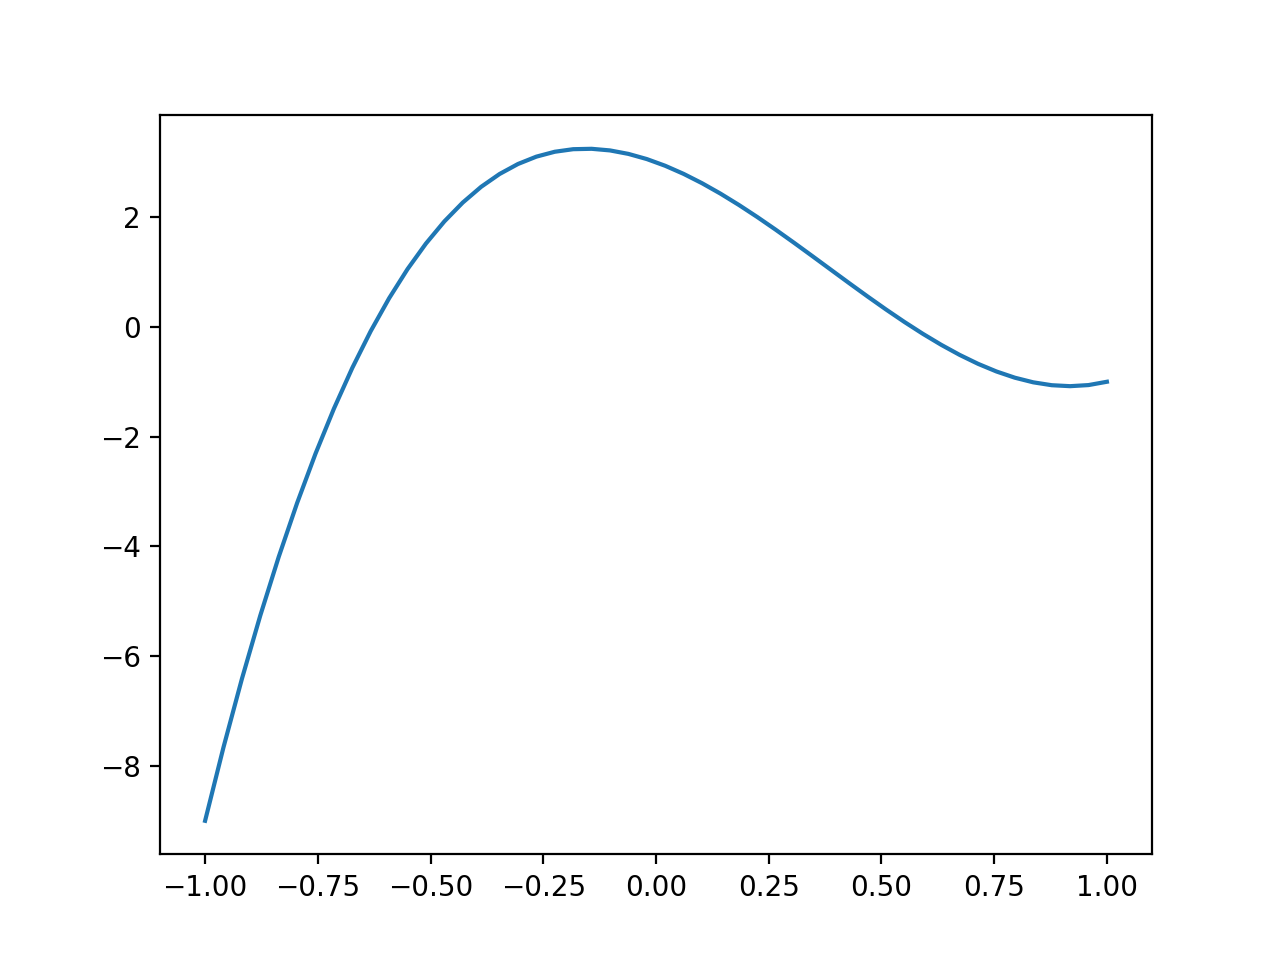

In [19]:
x = np.linspace(-1, 1)
fig, ax = plt.subplots()
ax.plot(x, p(x))
plt.show()

In [20]:
p.integ()(1) - p.integ()(-1)

0.6666666666666674

In [21]:
p(-np.sqrt(1 / 3)) + p(np.sqrt(1 / 3))

0.6666666666666665

### Optional: Use SymPy (Symbolic library for Python) to pretty print

In [22]:
from sympy.abc import x
import sympy

sympy.init_printing()

In [23]:
p(x).expand()

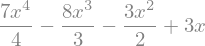

In [24]:
p(x).integrate(x).expand()

### Making Gaussian quadrature:

Slightly improved version:

In [26]:
max_in = 11

w = np.zeros(2001, dtype=np.float64)
x = np.zeros(2001, dtype=np.float64)


def func_e(x):
    return np.exp(-x)


def gauss(npts, job, a, b, x, w, vmin=0.0, vmax=0.0):
    m = i = j = t = t1 = pp = p1 = p2 = p3 = 0.0

    eps = 3e-14  # Accuracy: ******ADJUST THIS*******!
    m = (npts + 1) // 2
    for i in range(1, m + 1):
        t = np.cos(np.pi * (float(i) - 0.25) / (float(npts) + 0.5))

        t1 = 1
        while abs(t - t1) >= eps:
            p1 = 1.0
            p2 = 0.0
            for j in range(1, npts + 1):
                p3 = p2
                p2 = p1
                p1 = ((2.0 * float(j) - 1) * t * p2 - (float(j) - 1.0) * p3) / (
                    float(j)
                )
            pp = npts * (t * p1 - p2) / (t * t - 1.0)
            t1 = t
            t = t1 - p1 / pp

        x[i - 1] = -t
        x[npts - i] = t
        w[i - 1] = 2.0 / ((1.0 - t * t) * pp * pp)
        w[npts - i] = w[i - 1]

    if job == 0:
        for i in range(0, npts):
            x[i] = x[i] * (b - a) / 2.0 + (b + a) / 2.0
            w[i] = w[i] * (b - a) / 2.0

    if job == 1:
        for i in range(0, npts):
            xi = x[i]
            x[i] = a * b * (1.0 + xi) / (b + a - (b - a) * xi)
            w[i] = (
                w[i]
                * 2.0
                * a
                * b
                * b
                / ((b + a - (b - a) * xi) * (b + a - (b - a) * xi))
            )

    if job == 2:
        for i in range(0, npts):
            xi = x[i]
            x[i] = (b * xi + b + a + a) / (1.0 - xi)
            w[i] = w[i] * 2.0 * (a + b) / ((1.0 - xi) * (1.0 - xi))


def gaussint(no, min, max):
    quadra = 0.0
    gauss(no, 0, min, max, x, w)
    for n in range(0, no):
        quadra += func_e(x[n]) * w[n]
    return quadra


for i in range(3, max_in + 1, 2):
    result = gaussint(i, 0.0, 1.0)
    print(" i ", i, " err ", abs(result - 1 + 1 / np.exp(1)))

 i  3  err  3.0316449151079894e-07
 i  5  err  2.454703107446221e-13
 i  7  err  4.773959005888173e-15
 i  9  err  3.9968028886505635e-15
 i  11  err  1.0547118733938987e-14


Much better version:

In [27]:
def gauss_new(npts, job, a, b, vmin=0.0, vmax=0.0, eps=3e-14):

    x = np.zeros(npts, dtype=np.float64)
    w = np.zeros(npts, dtype=np.float64)

    for i in range((npts + 1) // 2):
        t = np.cos(np.pi * (i + 0.75) / (npts + 0.5))

        t1 = 1
        while abs(t - t1) >= eps:
            p1 = 1.0
            p2 = 0.0
            for j in range(npts):
                p3 = p2
                p2 = p1
                p1 = ((2 * j + 1) * t * p2 - j * p3) / (j + 1)

            pp = npts * (t * p1 - p2) / (t ** 2 - 1)
            t1 = t
            t = t1 - p1 / pp

        x[i] = -t
        x[~i] = t
        w[i] = 2 / ((1 - t ** 2) * pp ** 2)
        w[~i] = w[i]

    if job == 0:
        w = w * (b - a) / 2
        x = x * (b - a) / 2 + (b + a) / 2

    elif job == 1:
        # Use old x for w and x calcs
        w = w * 2 * a * b ** 2 / (b + a - (b - a) * x) ** 2
        x = a * b * (1 + x) / (b + a - (b - a) * x)

    elif job == 2:
        # Use old x for w and x calcs
        w = w * 2 * (a + b) / (1 - x) ** 2
        x = (b * x + b + 2 * a) / (1 - x)

    else:
        raise RuntimeError(f"Job ({job}) must be 0, 1, or 2")

    return x, w


def gaussint_new(f, no, min, max):
    quadra = 0.0
    x, w = gauss_new(no, 0, min, max)
    for n in range(no):
        quadra += f(x[n]) * w[n]
    return quadra


for i in range(3, max_in + 1, 2):
    result = gaussint_new(func_e, i, 0, 1)
    print("i", i, "err", abs(result - 1 + 1 / np.exp(1)))

i 3 err 3.0316449151079894e-07
i 5 err 2.454703107446221e-13
i 7 err 4.773959005888173e-15
i 9 err 4.107825191113079e-15
i 11 err 1.0547118733938987e-14


Using the classic `QUADPACK` from the Fortran days...

In [28]:
result, *_ = integrate.quad(func_e, 0, 1)
print(abs(result - 1 + 1 / np.exp(1)))

1.1102230246251565e-16


Using `fixed_quad`, which should be fairly similar to our algorithm:

In [29]:
for i in range(3, max_in + 1, 2):
    result, *_ = integrate.fixed_quad(func_e, 0, 1, n=i)
    print("i", i, "err", abs(result - 1 + 1 / np.exp(1)))

i 3 err 3.031644898454644e-07
i 5 err 2.404743071338089e-13
i 7 err 0.0
i 9 err 1.1102230246251565e-16
i 11 err 1.1102230246251565e-16


Look at the "See Also" section of the docstrings for the integration functions!